In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from mlxtend.plotting import plot_learning_curves
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef

In [ ]:
def countplot_data(data, feature):
    '''
        Method to compute countplot of given dataframe
        Parameters:
            data(pd.Dataframe): Input Dataframe
            feature(str): Feature in Dataframe
    '''
    plt.figure(figsize=(10,10))
    sns.countplot(x=feature, data=data)
    plt.show()


def pairplot_data_grid(data, feature1, feature2, target):
    '''
        Method to construct pairplot of the given feature wrt data
        Parameters:
            data(pd.DataFrame): Input Dataframe
            feature1(str): First Feature for Pair Plot
            feature2(str): Second Feature for Pair Plot
            target: Target or Label (y)
    '''

    sns.FacetGrid(data, hue=target, height=6).map(plt.scatter, feature1, feature2).add_legend()
    plt.show()


In [ ]:
df = pd.read_csv('/content/drive/My Drive/МКР/creditcard.csv')

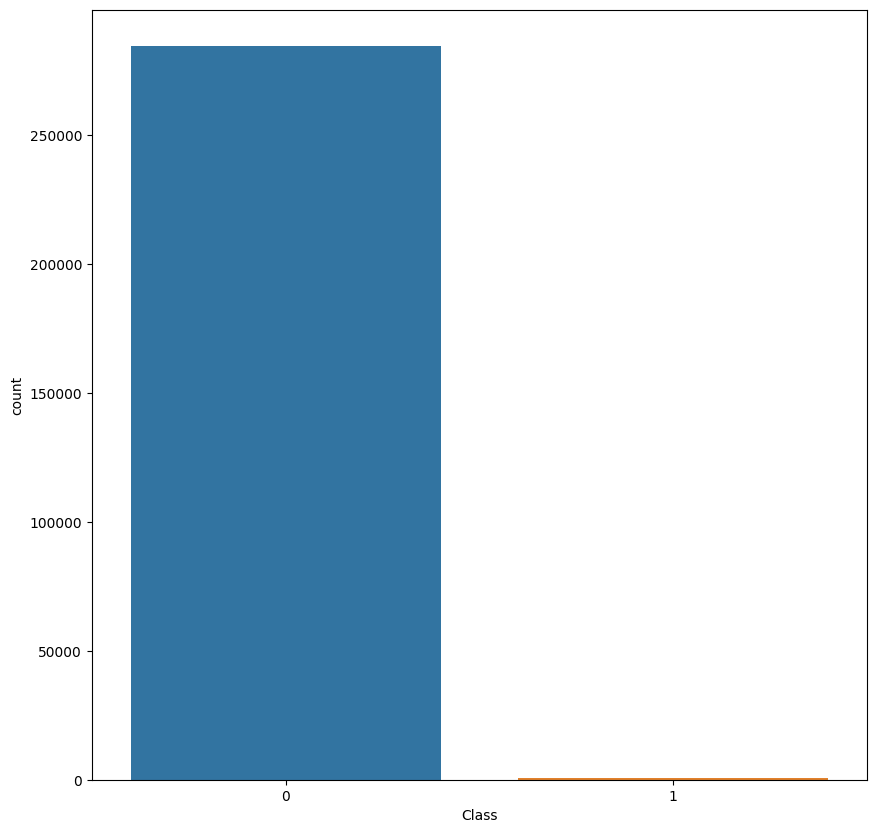

In [ ]:
countplot_data(df, df.Class)

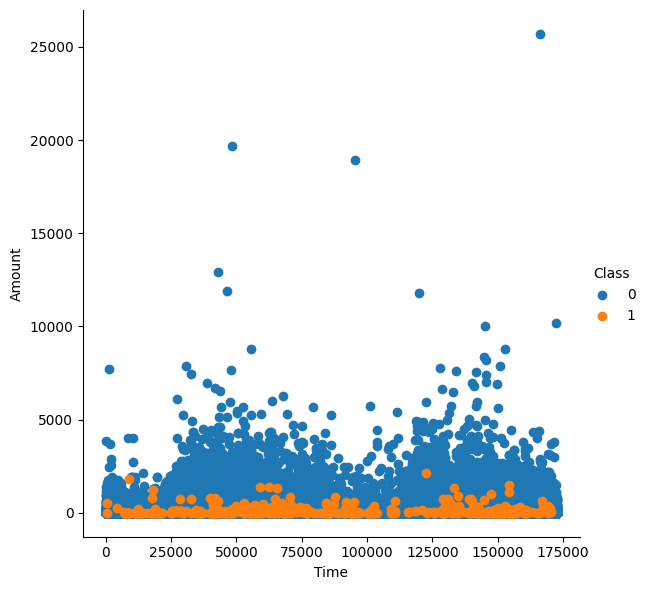

In [ ]:
pairplot_data_grid(df, "Time", "Amount", "Class")

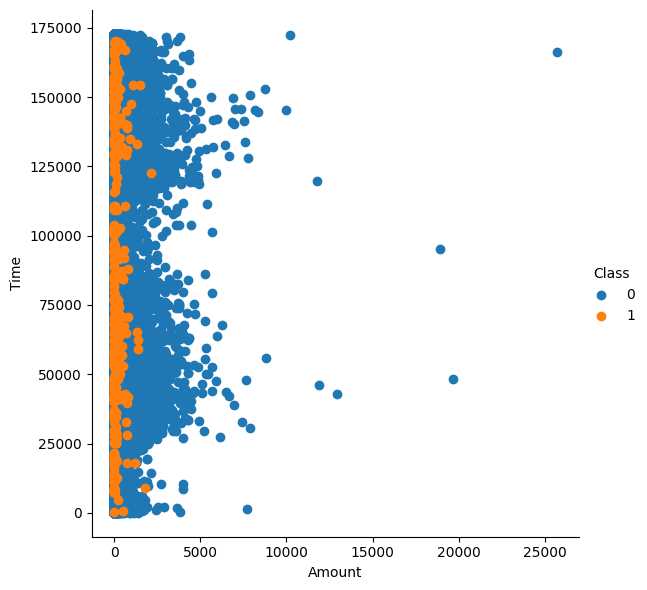

In [ ]:
pairplot_data_grid(df, "Amount", "Time", "Class")

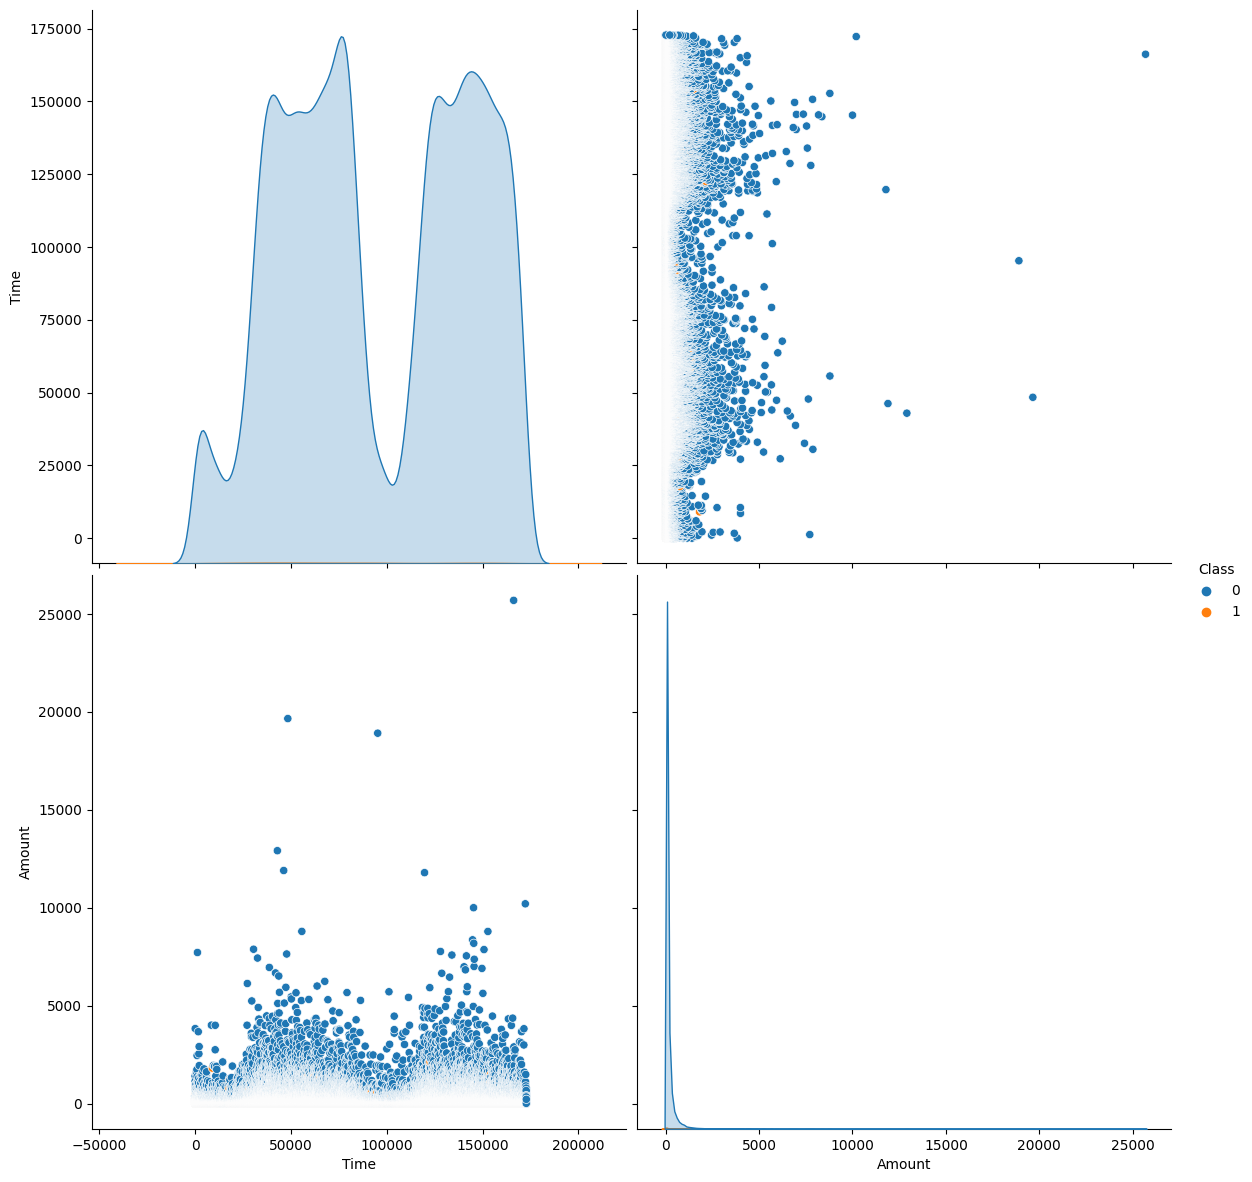

In [ ]:
df_refine = df[["Time", "Amount", "Class"]]
sns.pairplot(df_refine, hue="Class", height=6)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


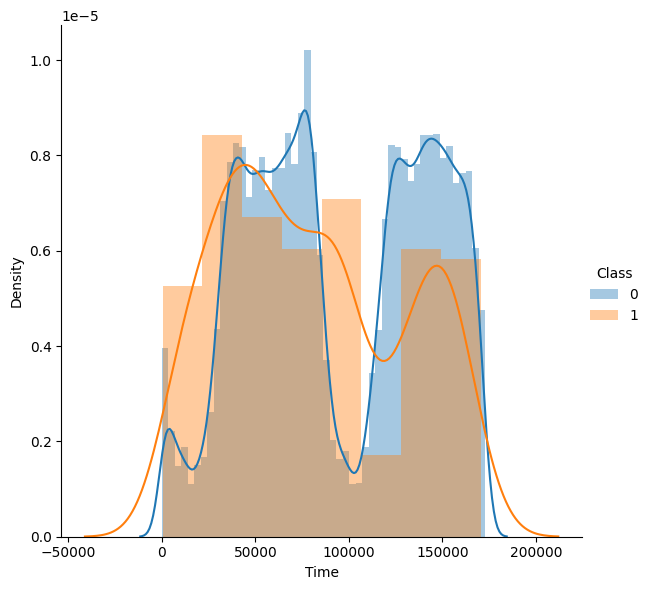

In [ ]:
sns.FacetGrid(df_refine, hue="Class", height=6).map(sns.distplot,"Time").add_legend()
plt.show()

In [ ]:
# Create Train and Test Data in ratio 70:30
X = df.drop(labels='Class', axis=1) # Features
y = df.loc[:,'Class']               # Target Variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

##Balancing


In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mutual_infos = pd.Series(data=mutual_info_classif(X_res, y_res, discrete_features=False, random_state=1), index=X_train.columns)

In [ ]:
mutual_infos.sort_values(ascending=False)

V14       0.535044
V10       0.464775
V12       0.456052
V17       0.438193
V4        0.427427
V11       0.404040
Amount    0.392909
V3        0.387187
V16       0.335317
V7        0.304171
V2        0.291484
V9        0.256678
Time      0.247989
V21       0.235010
V27       0.229914
V1        0.220736
V18       0.198262
V8        0.174371
V6        0.171973
V28       0.170495
V5        0.157362
V20       0.107488
V19       0.099836
V23       0.067332
V24       0.063567
V26       0.046974
V25       0.031606
V22       0.031539
V13       0.024931
V15       0.022442
dtype: float64

<Axes: ylabel='count'>

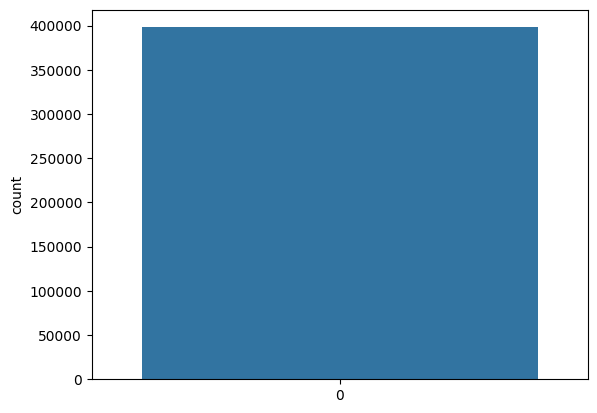

In [ ]:
sns.countplot(y_res)

In [ ]:
# Evaluation of Classifiers
def grid_eval(grid_clf):
    """
        Method to Compute the best score and parameters computed by grid search
        Parameter:
            grid_clf: The Grid Search Classifier
    """
    print("Best Score", grid_clf.best_score_)
    print("Best Parameter", grid_clf.best_params_)

def evaluation(y_test, grid_clf, X_test):
    """
        Method to compute the following:
            1. Classification Report
            2. F1-score
            3. AUC-ROC score
            4. Accuracy
        Parameters:
            y_test: The target variable test set
            grid_clf: Grid classifier selected
            X_test: Input Feature Test Set
    """
    y_pred = grid_clf.predict(X_test)
    print('CLASSIFICATION REPORT')
    print(classification_report(y_test, y_pred))

    print('AUC-ROC')
    print(roc_auc_score(y_test, y_pred))

    print('F1-Score')
    print(f1_score(y_test, y_pred))

    print('Accuracy')
    print(accuracy_score(y_test, y_pred))

In [ ]:
# The parameters of each classifier are different
# Hence, we do not make use of a single method and this is not to violate DRY Principles
# We set pipelines for each classifier unique with parameters
param_grid_sgd = [{
    'model__loss': ['log'],
    'model__penalty': ['l1', 'l2'],
    'model__alpha': np.logspace(start=-3, stop=3, num=20)
}, {
    'model__loss': ['hinge'],
    'model__alpha': np.logspace(start=-3, stop=3, num=20),
    'model__class_weight': [None, 'balanced']
}]

pipeline_sgd = Pipeline([
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

MCC_scorer = make_scorer(matthews_corrcoef)
grid_sgd = GridSearchCV(estimator=pipeline_sgd, param_grid=param_grid_sgd, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)


grid_sgd.fit(X_res, y_res)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler(copy=False)),
                                       ('model',
                                        SGDClassifier(random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid=[{'model__alpha': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00,...
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                          'model__class_weight': [None, 'balanced'],
                          'model__loss': ['hinge']}],
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [ ]:
grid_eval(grid_sgd)

Best Score 0.9560162686072134
Best Parameter {'model__alpha': 0.001, 'model__loss': 'log', 'model__penalty': 'l1'}


In [ ]:
evaluation(y_test, grid_sgd, X_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.14      0.91      0.25       148

    accuracy                           0.99     85443
   macro avg       0.57      0.95      0.62     85443
weighted avg       1.00      0.99      0.99     85443

AUC-ROC
0.9479720619851928
F1-Score
0.2460973370064279
Accuracy
0.990391254988706


In [ ]:
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])
param_grid_rf = {'model__n_estimators': [75]}
grid_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_rf.fit(X_res, y_res)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             n_jobs=-1, param_grid={'model__n_estimators': [75]},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [ ]:
grid_eval(grid_rf)

Best Score 0.9997538267139271
Best Parameter {'model__n_estimators': 75}


In [ ]:
evaluation(y_test, grid_rf, X_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.90      0.86      0.88       148

    accuracy                           1.00     85443
   macro avg       0.95      0.93      0.94     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC
0.9323445023075716
F1-Score
0.879725085910653
Accuracy
0.9995903701883126


In [ ]:
pipeline_lr = Pipeline([
    ('model', LogisticRegression(random_state=1))
])
param_grid_lr = {'model__penalty': ['l2'],
                 'model__class_weight': [None, 'balanced']}
grid_lr = GridSearchCV(estimator=pipeline_lr, param_grid=param_grid_lr, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_lr.fit(X_res, y_res)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        LogisticRegression(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__class_weight': [None, 'balanced'],
                         'model__penalty': ['l2']},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [ ]:
grid_eval(grid_lr)

Best Score 0.959816277887179
Best Parameter {'model__class_weight': None, 'model__penalty': 'l2'}


In [ ]:
evaluation(y_test, grid_lr, X_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.15      0.91      0.26       148

    accuracy                           0.99     85443
   macro avg       0.57      0.95      0.63     85443
weighted avg       1.00      0.99      0.99     85443

AUC-ROC
0.948212404326479
F1-Score
0.2557251908396946
Accuracy
0.9908711070538253


In [ ]:
pipeline_knn = Pipeline([
    ('model', KNeighborsClassifier(n_neighbors=5))
])
param_grid_knn = {'model__p': [2]}
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
grid_knn.fit(X_res, y_res)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', KNeighborsClassifier())]),
             n_jobs=-1, param_grid={'model__p': [2]},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [ ]:
grid_eval(grid_knn)

Best Score 0.9980623930056313
Best Parameter {'model__p': 2}


In [ ]:
evaluation(y_test, grid_knn, X_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.50      0.86      0.63       148

    accuracy                           1.00     85443
   macro avg       0.75      0.93      0.82     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC
0.9283095789968995
F1-Score
0.6318407960199005
Accuracy
0.9982678510820079
